<a href="https://colab.research.google.com/github/DingLi23/COMP6231/blob/main/Resnet_Pneumonia_hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introducation**

This notebook create pneumonia prediction based on Residual CNN(ResNet).

Student: Ding Li

Student ID: 40160073

**1. enviornment**






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Apr  6 17:21:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import os
import cv2
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm    
import seaborn as sn
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import BatchNormalization, Conv2D, Activation, Dropout, add, Input, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator    
from keras import optimizers
from keras.callbacks import EarlyStopping

**2. Load Images and save data in numpy**

In [ ]:
#paramters
image_size = 100

#load images save as numpay
def load_image(file,label):
    files = np.array(os.listdir(file))
    if(label == 'normal'):
      labels = np.zeros(len(files)) #in which class 0 represent normal
    else:
      labels = np.ones(len(files)) # class 1 represent pneumonia

    images = []
    for image in tqdm(files):
        image = cv2.imread(file + image)
        image = cv2.resize(image, dsize=(image_size,image_size))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)

    images = np.array(images)
    return images, labels

test_images_normal, test_label_normal = load_image('/content/drive/My Drive/COMP6321/chest_xray/test/NORMAL/','normal')
test_images_pneumonia, test_label_pneumonia = load_image('/content/drive/My Drive/COMP6321/chest_xray/test/PNEUMONIA/','pneumonia')
train_images_normal, train_label_normal = load_image('/content/drive/My Drive/COMP6321/chest_xray/train/NORMAL/','normal')
train_images_pneumonia, train_label_pneumonia = load_image('/content/drive/My Drive/COMP6321/chest_xray/train/PNEUMONIA/','pneumonia')
val_images_normal, val_label_normal = load_image('/content/drive/My Drive/COMP6321/chest_xray/val/NORMAL/','normal')
val_images_pneumonia, val_label_pneumonia = load_image('/content/drive/My Drive/COMP6321/chest_xray/val/PNEUMONIA/','pneumonia')


X_train = np.append(train_images_normal, train_images_pneumonia, axis=0)
y_train = np.append(train_label_normal, train_label_pneumonia)
X_test = np.append(test_images_normal, test_images_pneumonia, axis=0)
y_test = np.append(test_label_normal, test_label_pneumonia)
X_val = np.append(val_images_normal, val_images_pneumonia, axis=0)
y_val = np.append(val_label_normal, val_label_pneumonia)

print('finish loading images')


save data as pickle for next use

In [4]:
# import pickle
# with open('/content/drive/My Drive/COMP6321/chest_xray/pneumonia_data.pickle', 'wb') as f:
#     pickle.dump((X_train, X_test, X_val, y_train, y_test, y_val), f)

with open('/content/drive/My Drive/COMP6321/chest_xray/pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, X_val, y_train, y_test, y_val) = pickle.load(f)

print(X_test.shape)
print(y_train.shape)

(624, 100, 100)
(5229,)


**3. Pre-process the data**

In [5]:

# the pre-process strategy is refer to https://gist.github.com/MuhammadArdiPutra/f7ad4ab7839ea2f1491ab8d1b32601cd
# for label data, convert one-hot encodeing before training
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = one_hot_encoder.fit_transform(y_train[:, np.newaxis])
y_test_onehot = one_hot_encoder.transform(y_test[:, np.newaxis])
y_val_onehot = one_hot_encoder.transform(y_val[:, np.newaxis])

# reshape training dataset
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)


#create training dataset generator for the ResNet
image_generator = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

image_generator.fit(X_train)

**4. Training data in Residual CNN network**


In [6]:
# plot,print,visualize
def plot_loss_and_acc(model_fit,value1,value2,title):
  plt.figure(figsize=(6,4))
  plt.title(title)
  plt.plot(model_fit.history[value1],color = 'b')
  plt.plot(model_fit.history[value2],color = 'green')
  plt.legend([value1, value2])
  plt.show()

def calculate_performance(confusion_matrix,score):
  recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
  precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
  avg_recall = np.mean(recall)
  avg_precision = np.mean(precision)
  print('test_avg_precision:',avg_precision,'\n','test_avg_recall:',avg_recall,'\n','test_loss:', score[0], '\n', 'test_accuracy:', score[1])
  return score[1]

def visualize_cm(confusion_matrix):
  df_confusion_matrix = pd.DataFrame(confusion_matrix)
  ax = sn.heatmap(confusion_matrix,annot=True,fmt='d',cmap=plt.cm.Greens)
  ax.set_title('confusion matrix (0: normal, 1: pneumonia)')
  ax.set_xlabel('predict') 


# build Resnet network, the network is cited from the NLP project of my research group, which build a 20-layer residual convolutional neural network.
# https://github.com/OneClickDeepLearning/classificationOfResidentialRequests

def bn_relu(layer, dropout=0, **params):
    layer = BatchNormalization()(layer)
    layer = Activation(params['conv_activation'])(layer)

    if dropout > 0:
        layer = Dropout(dropout)(layer)
    return layer

def res_block(input, filters, stride, dim_up=False):
    if dim_up:
        shortcut = Conv2D(filters=filters,
                          kernel_size=[1, 1],
                          use_bias=False)(input)
    else:
        shortcut = input

    layer = Conv2D(filters=filters,
                   kernel_size=[1, stride],
                   kernel_initializer='random_uniform',
                   padding='same')(input)
    layer = bn_relu(layer, conv_activation='relu')
    layer = Conv2D(filters=filters,
                   kernel_size=[1, stride],
                   kernel_initializer='random_uniform',
                   padding='same')(layer)
    layer = add([layer, shortcut])
    layer = bn_relu(layer, conv_activation='relu')
    return layer

def network(num,model_summary):
    input = Input(shape=[100, 100, 1])
    layer = Conv2D(filters=64, kernel_size=[1, 100], strides=[1, 100], kernel_initializer='random_uniform')(input)
    layer = bn_relu(layer, conv_activation='relu')
    layer = res_block(layer, 64, stride=2)
    layer = res_block(layer, 128, stride=4, dim_up=True)
    layer = res_block(layer, 256, stride=8, dim_up=True)
    layer = res_block(layer, 512, stride=16, dim_up=True)
    layer = Flatten()(layer)
    output = Dense(num, activation='softmax')(layer)
    model = Model(inputs=[input], outputs=[output])
    if model_summary:
      model.summary()
    return model


# training the model with hyper_parameters.
def train_hyperpara(batch_size, lr, X_train, y_train_onehot, X_test, y_test_onehot,verbose=1,model_summary=1):

  model = network(2,model_summary)
  train_generator = image_generator.flow(X_train, y_train_onehot, batch_size)
  adam = optimizers.Adam(lr = lr)
  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

  # choice earlystopping as model saving strategy
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=verbose, mode='auto')

  model_fit = model.fit(train_generator, 
                        epochs=30, 
                        validation_data=(X_test, y_test_onehot),
                        callbacks = [monitor],
                        verbose=verbose)

  # model.save('/content/drive/My Drive/COMP6321/chest_xray/pneumonia_resnet.h5')

  #plot training acc and loss
  plot_loss_and_acc(model_fit,'accuracy','val_accuracy','Accuracy')
  plot_loss_and_acc(model_fit,'loss','val_loss','Loss')

  #calculate scores.
  predictions = model.predict(X_test)
  predictions = one_hot_encoder.inverse_transform(predictions)
  test_generator = image_generator.flow(X_test, y_test_onehot, batch_size)
  score = model.evaluate(test_generator)

  #visualize_cm and print scores.
  con_mat = confusion_matrix(y_test, predictions, labels=[0,1])
  acc = calculate_performance(con_mat,score)
  visualize_cm(con_mat)
  return acc


**5. No HyperParameter Training and test result**

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 100, 1, 64)   6464        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_90 (BatchNo (None, 100, 1, 64)   256         conv2d_120[0][0]                 
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 100, 1, 64)   0           batch_normalization_90[0][0]     
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


82/82 [==============================] - 8s 87ms/step - loss: 2.3120 - accuracy: 0.7490 - val_loss: 1.9786 - val_accuracy: 0.4327
Epoch 2/30
82/82 [==============================] - 7s 84ms/step - loss: 0.4308 - accuracy: 0.8814 - val_loss: 1.4683 - val_accuracy: 0.6330
Epoch 3/30
82/82 [==============================] - 7s 85ms/step - loss: 0.2897 - accuracy: 0.8903 - val_loss: 1.0152 - val_accuracy: 0.7372
Epoch 4/30
82/82 [==============================] - 7s 84ms/step - loss: 0.2543 - accuracy: 0.9140 - val_loss: 0.7586 - val_accuracy: 0.7708
Epoch 5/30
82/82 [==============================] - 7s 84ms/step - loss: 0.2119 - accuracy: 0.9187 - val_loss: 0.4234 - val_accuracy: 0.7997
Epoch 6/30
82/82 [==============================] - 7s 84ms/step - loss: 0.2469 - accuracy: 0.9064 - val_loss: 0.5378 - val_accuracy: 0.8141
Epoch 7/30
82/82 [==============================] - 7s 84ms/step - loss: 0.2274 - accuracy: 0.9194 - val_loss: 0.2981 - val_accuracy: 0.8718
Epoch 8/30
82/82 [======

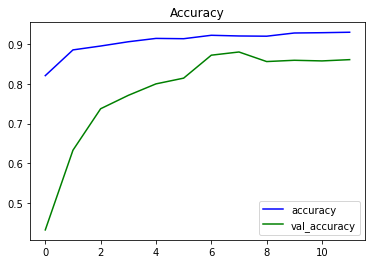

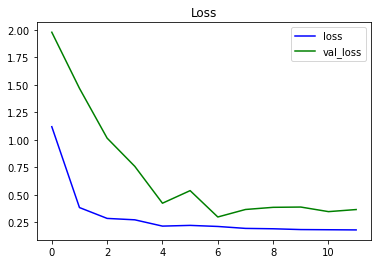

10/10 [==============================] - 1s 57ms/step - loss: 0.4388 - accuracy: 0.8462
test_avg_precision: 0.8575846596972792 
 test_avg_recall: 0.8414529914529914 
 test_loss: 0.4388154447078705 
 test_accuracy: 0.8461538553237915


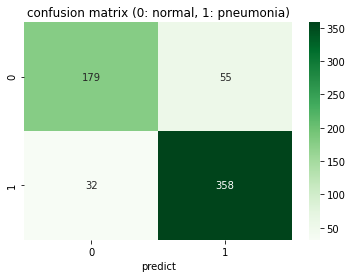

In [23]:
train_hyperpara(64, 0.001, X_train, y_train_onehot, X_test, y_test_onehot,verbose=1, model_summary = 1)

**6. HyperParameter Grid Search**

training round: 1 , learnring rate: 0.01 , batch_size: 32


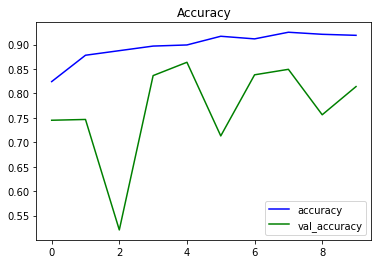

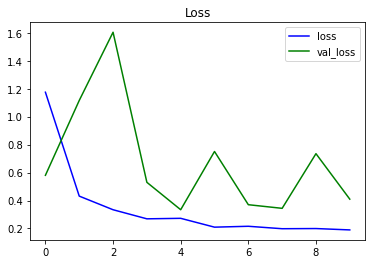

20/20 [==============================] - 1s 30ms/step - loss: 0.4687 - accuracy: 0.8157
test_avg_precision: 0.8016483516483517 
 test_avg_recall: 0.8128205128205128 
 test_loss: 0.46866315603256226 
 test_accuracy: 0.8157051205635071
training round: 2 , learnring rate: 0.01 , batch_size: 64


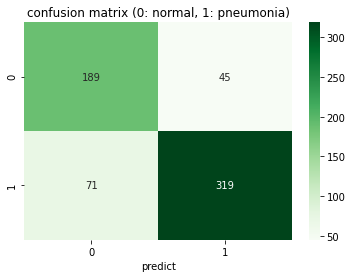

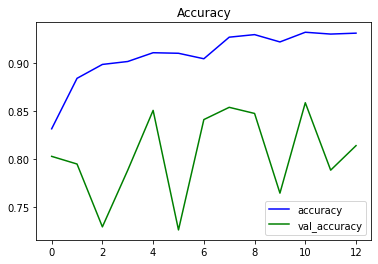

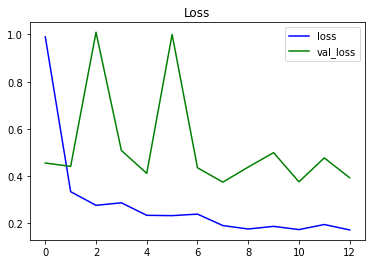

10/10 [==============================] - 1s 79ms/step - loss: 0.4542 - accuracy: 0.8205
test_avg_precision: 0.8058095750403442 
 test_avg_recall: 0.8239316239316239 
 test_loss: 0.454183429479599 
 test_accuracy: 0.8205128312110901
training round: 3 , learnring rate: 0.01 , batch_size: 128


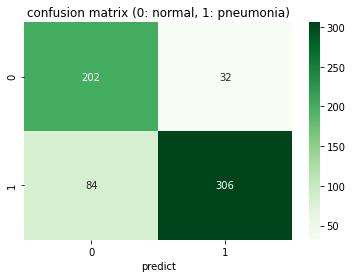

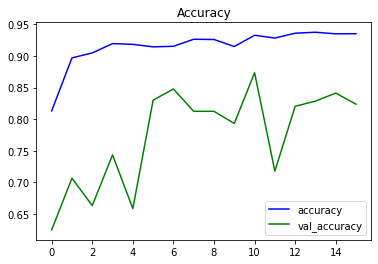

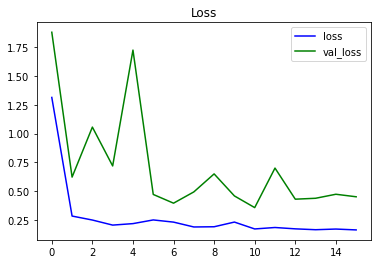

5/5 [==============================] - 1s 198ms/step - loss: 0.4534 - accuracy: 0.8061
test_avg_precision: 0.8175633889919605 
 test_avg_recall: 0.8376068376068376 
 test_loss: 0.4534085988998413 
 test_accuracy: 0.8060897588729858
training round: 4 , learnring rate: 0.01 , batch_size: 256


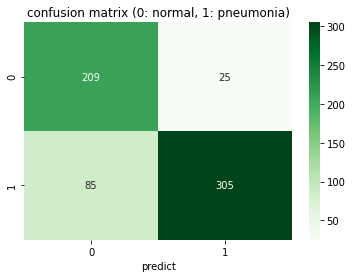

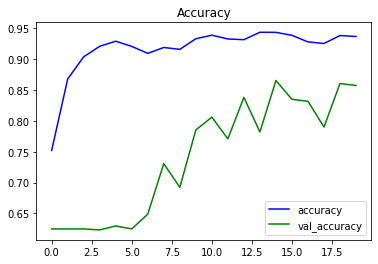

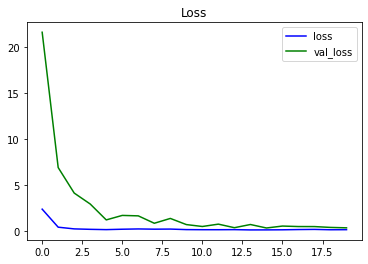

3/3 [==============================] - 1s 151ms/step - loss: 0.4883 - accuracy: 0.8237
test_avg_precision: 0.8673582466293173 
 test_avg_recall: 0.8269230769230769 
 test_loss: 0.4883106052875519 
 test_accuracy: 0.8237179517745972
training round: 5 , learnring rate: 0.001 , batch_size: 32


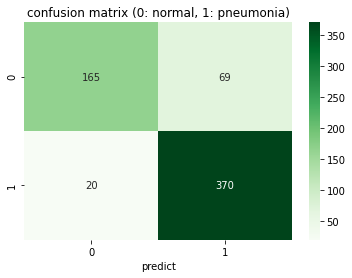

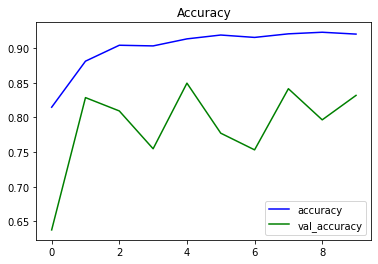

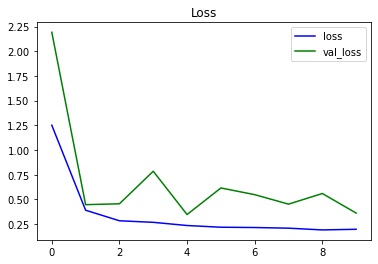

20/20 [==============================] - 1s 32ms/step - loss: 0.4130 - accuracy: 0.8317
test_avg_precision: 0.8198487589785814 
 test_avg_recall: 0.8235042735042735 
 test_loss: 0.41296884417533875 
 test_accuracy: 0.8317307829856873
training round: 6 , learnring rate: 0.001 , batch_size: 64


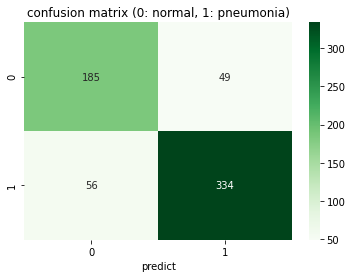

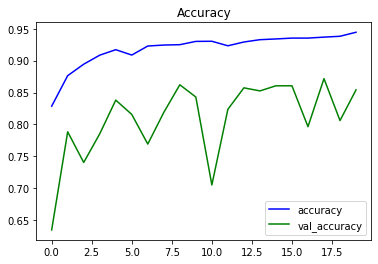

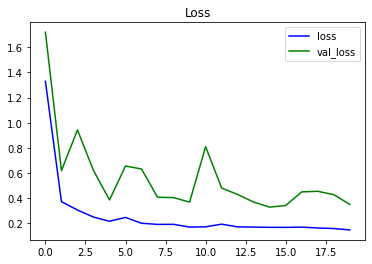

10/10 [==============================] - 1s 59ms/step - loss: 0.3950 - accuracy: 0.8269
test_avg_precision: 0.8435099617563893 
 test_avg_recall: 0.8474358974358974 
 test_loss: 0.3949846029281616 
 test_accuracy: 0.8269230723381042
training round: 7 , learnring rate: 0.001 , batch_size: 128


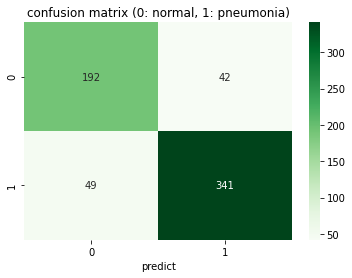

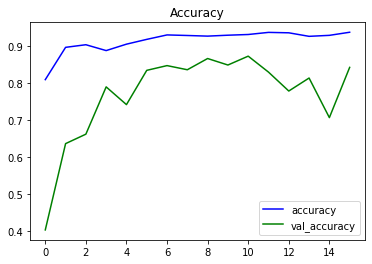

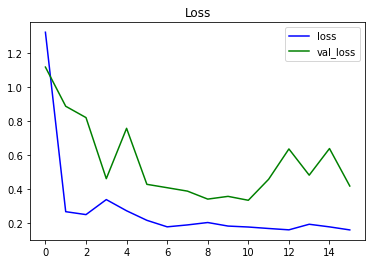

5/5 [==============================] - 1s 111ms/step - loss: 0.4860 - accuracy: 0.7981
test_avg_precision: 0.8440301354186535 
 test_avg_recall: 0.8162393162393162 
 test_loss: 0.4860372841358185 
 test_accuracy: 0.7980769276618958
training round: 8 , learnring rate: 0.001 , batch_size: 256


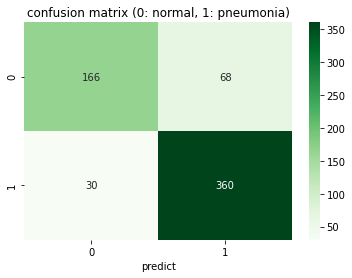

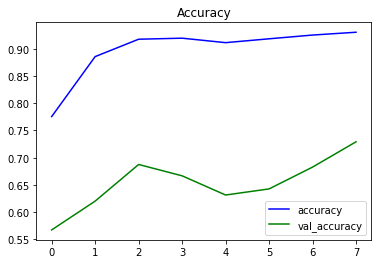

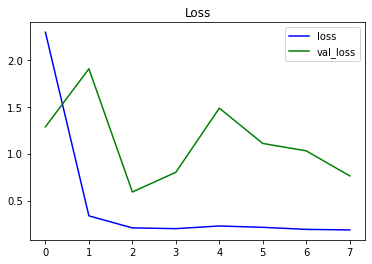

3/3 [==============================] - 1s 149ms/step - loss: 0.7916 - accuracy: 0.7244
test_avg_precision: 0.817304189435337 
 test_avg_recall: 0.6431623931623932 
 test_loss: 0.7916081547737122 
 test_accuracy: 0.7243589758872986
training round: 9 , learnring rate: 0.0001 , batch_size: 32


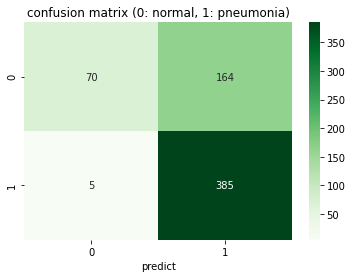

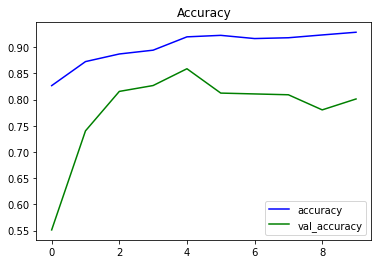

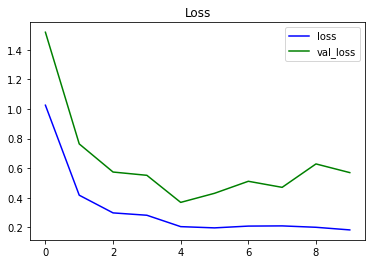

20/20 [==============================] - 1s 32ms/step - loss: 0.5793 - accuracy: 0.8077
test_avg_precision: 0.8384763741562199 
 test_avg_recall: 0.7461538461538462 
 test_loss: 0.5793336033821106 
 test_accuracy: 0.807692289352417
training round: 10 , learnring rate: 0.0001 , batch_size: 64


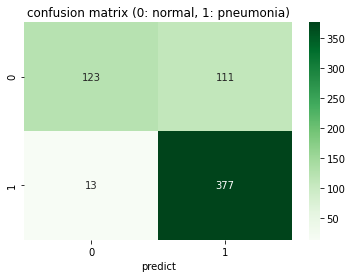

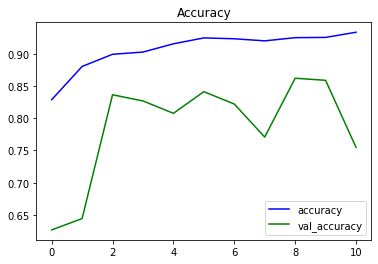

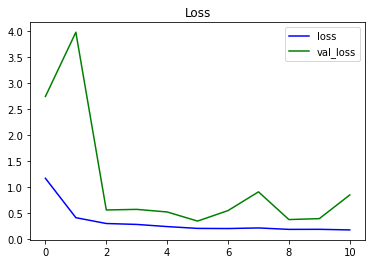

10/10 [==============================] - 1s 62ms/step - loss: 0.6484 - accuracy: 0.7917
test_avg_precision: 0.8251616754551786 
 test_avg_recall: 0.6790598290598291 
 test_loss: 0.6483591794967651 
 test_accuracy: 0.7916666865348816
training round: 11 , learnring rate: 0.0001 , batch_size: 128


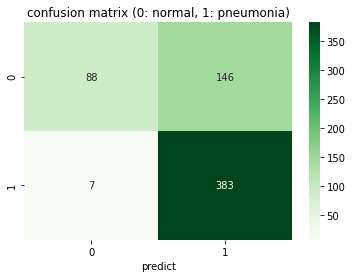

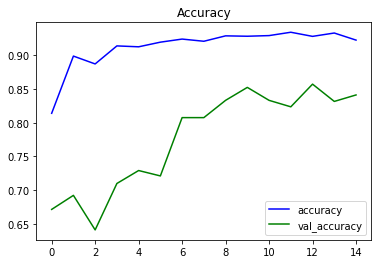

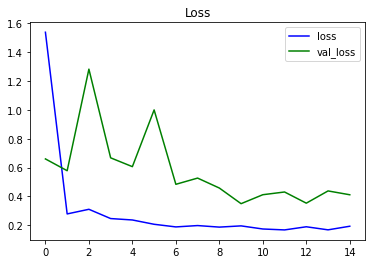

5/5 [==============================] - 1s 110ms/step - loss: 0.5369 - accuracy: 0.8189
test_avg_precision: 0.8303895594151702 
 test_avg_recall: 0.832051282051282 
 test_loss: 0.5369071364402771 
 test_accuracy: 0.8189102411270142
training round: 12 , learnring rate: 0.0001 , batch_size: 256


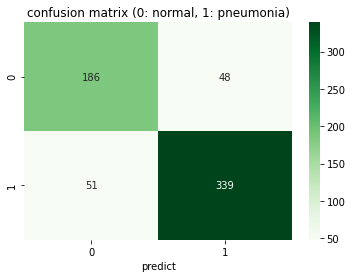

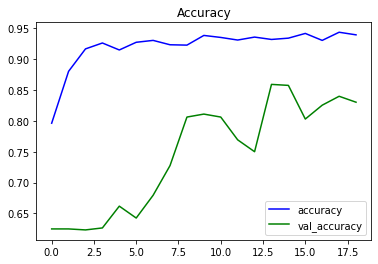

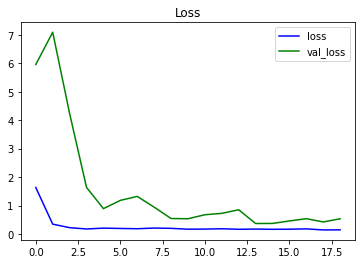

3/3 [==============================] - 1s 148ms/step - loss: 0.6000 - accuracy: 0.8061
test_avg_precision: 0.8403003246753247 
 test_avg_recall: 0.7940170940170941 
 test_loss: 0.5999841094017029 
 test_accuracy: 0.8060897588729858
training round: 13 , learnring rate: 1e-05 , batch_size: 32


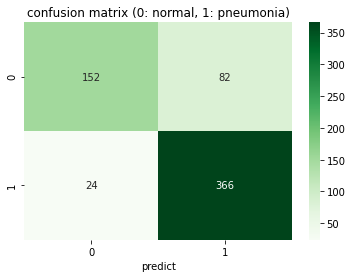

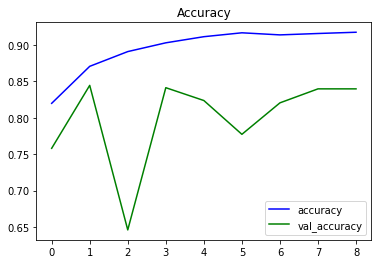

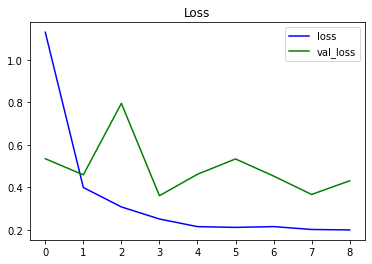

20/20 [==============================] - 1s 32ms/step - loss: 0.5682 - accuracy: 0.7772
test_avg_precision: 0.8551656719489606 
 test_avg_recall: 0.8025641025641026 
 test_loss: 0.5682398080825806 
 test_accuracy: 0.7772436141967773
training round: 14 , learnring rate: 1e-05 , batch_size: 64


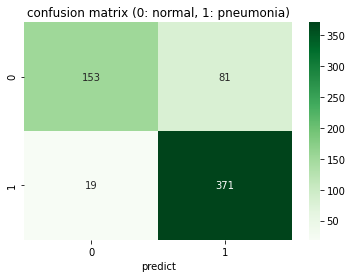

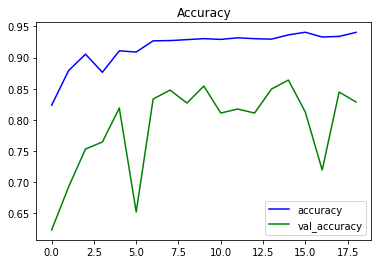

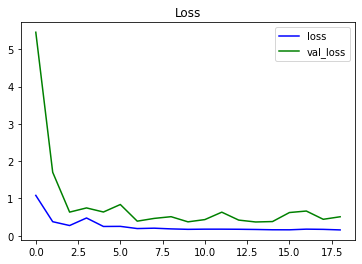

10/10 [==============================] - 1s 61ms/step - loss: 0.7229 - accuracy: 0.7885
test_avg_precision: 0.8770290322097154 
 test_avg_recall: 0.7756410256410257 
 test_loss: 0.7229197025299072 
 test_accuracy: 0.7884615659713745
training round: 15 , learnring rate: 1e-05 , batch_size: 128


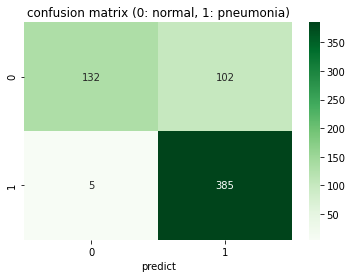

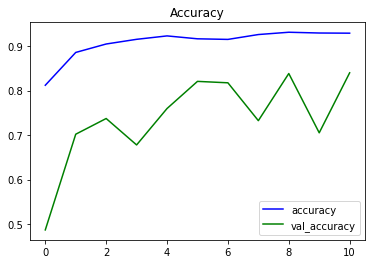

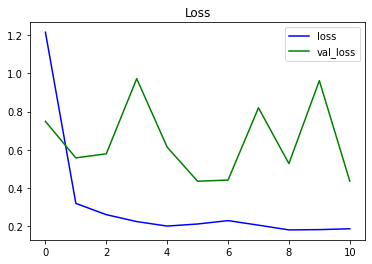

5/5 [==============================] - 1s 110ms/step - loss: 0.4480 - accuracy: 0.8429
test_avg_precision: 0.8278702445652174 
 test_avg_recall: 0.8384615384615385 
 test_loss: 0.4480442702770233 
 test_accuracy: 0.8429487347602844
training round: 16 , learnring rate: 1e-05 , batch_size: 256


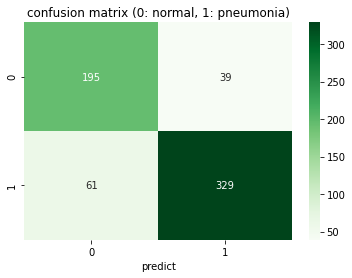

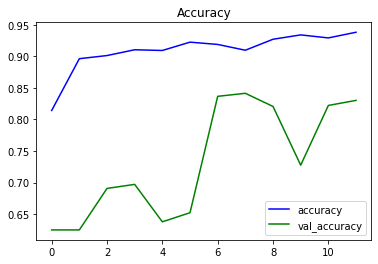

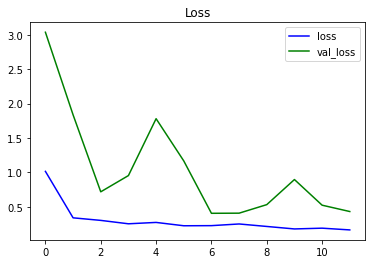

3/3 [==============================] - 1s 154ms/step - loss: 0.5220 - accuracy: 0.7949
test_avg_precision: 0.8416858237547893 
 test_avg_recall: 0.7931623931623932 
 test_loss: 0.52203768491745 
 test_accuracy: 0.7948718070983887


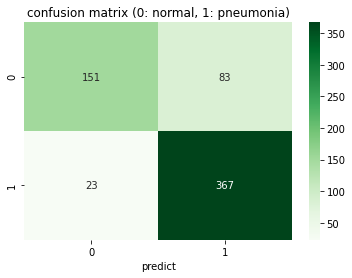

In [7]:
lr_list = [0.01, 0.001, 0.0001, 0.00001]
batch_size_list = [32, 64, 128, 256]
acc_append = []
round = 0
for i in range(len(lr_list)):
  for j in range(len(batch_size_list)):
    round += 1
    print('training round:', round, ', learnring rate:',lr_list[i], ', batch_size:',batch_size_list[j])
    acc = train_hyperpara(batch_size_list[j], lr_list[i], X_train, y_train_onehot, X_test, y_test_onehot, verbose=0, model_summary = 0)
    acc_append.append(acc)

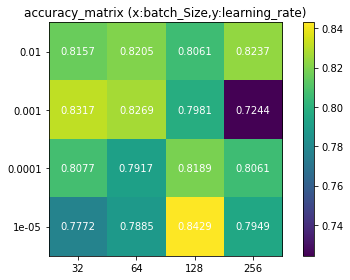

In [13]:
acc_append = np.array(acc_append).reshape(4,4)

x_axis = [32,64,128,256]
y_axis = [1e-02,1e-03,1e-04,1e-05]

fig, ax = plt.subplots()
im = ax.imshow(acc_append)

ax.set_xticks(np.arange(len(x_axis)))
ax.set_yticks(np.arange(len(y_axis)))

ax.set_xticklabels(x_axis)
ax.set_yticklabels(y_axis)

for i in range(len(y_axis)):
    for j in range(len(x_axis)):
        text = ax.text(j, i, format(acc_append[i,j],'.4f'),
                       ha="center", va="center", color="w")
ax.set_title("accuracy_matrix (x:batch_Size,y:learning_rate)")
fig.tight_layout()
plt.colorbar(im)
plt.show()